In [1]:
import pycpt # https://github.com/j08lue/pycpt
import numpy as np
from osgeo import gdal, osr
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:
# Read the input data
input_dem = r"..\Data\N46E009.hgt"
dem_src = gdal.Open(input_dem)

In [3]:
# Get raster projection
prj = dem_src.GetProjection()

# Create SpatialReference from prj
srs = osr.SpatialReference(wkt=prj)

# Get raster first band
dem_band = dem_src.GetRasterBand(1)

# Get raster as array
dem_array = dem_band.ReadAsArray()

In [4]:
# Scale
scale = 111120 if srs.IsGeographic() else 1.0

In [5]:
# Calculate Multidirectional hillshade
multidirectional = gdal.DEMProcessing('', dem_src, 'hillshade', multiDirectional=True, computeEdges=False,
                                      format='MEM', scale = scale)

multidirectional_array = multidirectional.ReadAsArray()

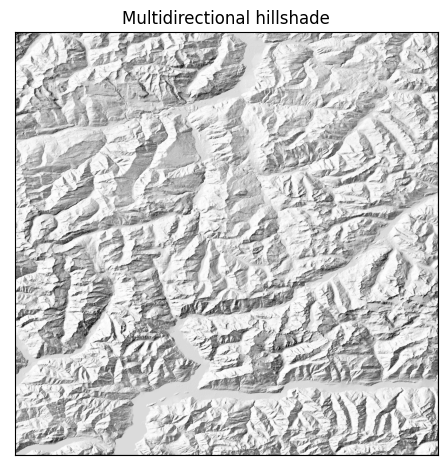

In [6]:
# Plot the multidirectional hillshade
fig, ax = plt.subplots()
ax.set_title("Multidirectional hillshade")

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.imshow(multidirectional_array, cmap="Greys_r")
plt.tight_layout()

In [7]:
# Calculate Slope and Aspect
slope = gdal.DEMProcessing('', dem_src, 'slope', computeEdges=False,
                          format='MEM', scale = scale)

aspect = gdal.DEMProcessing('', dem_src, 'aspect', computeEdges=False,
                          format='MEM', scale = scale)

# Get nodata value
nodata = aspect.GetRasterBand(1).GetNoDataValue()

slope_array = slope.ReadAsArray()
aspect_array = aspect.ReadAsArray()

# Mask nodata values
slope_ma = np.ma.array(slope_array, mask=slope_array==nodata)
aspect_ma = np.ma.array(aspect_array, mask=aspect_array==nodata)

# Apply Color ramp to aspect: https://github.com/OSGeo/gdal/files/4799962/aspect_ramp_continuous.txt
aspect_clr = gdal.DEMProcessing("", aspect, "color-relief", colorFilename="aspect_ramp_continuous.txt", format='MEM', computeEdges=False)
aspect_clr_array = np.transpose(aspect_clr.ReadAsArray(),(1,2,0))

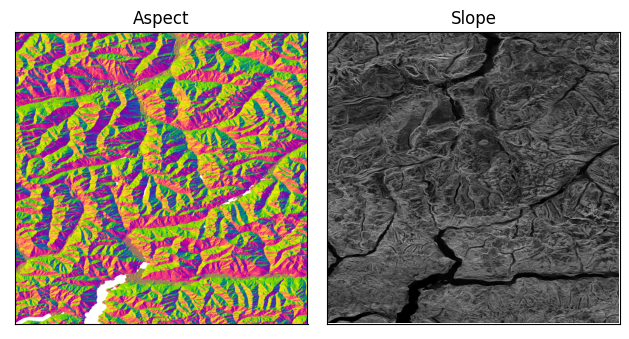

In [8]:
# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Aspect")
ax2.set_title("Slope")

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

# Plot the Aspect
ax1.imshow(aspect_clr_array)

# Plot the Slope
ax2.imshow(slope_ma, cmap="gist_gray")
plt.tight_layout()

In [9]:
# Load the europe colormap from cpt-city (http://soliton.vm.bytemark.co.uk/pub/cpt-city/)
europe_cmap = pycpt.load.cmap_from_cptcity_url('esri/hypsometry/eu/europe_3.cpt')

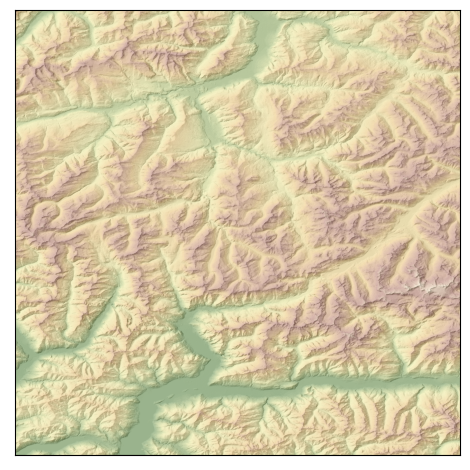

In [10]:
# Plot the Shaded relief
fig, ax = plt.subplots()

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Plot the multidirectional hillshade
ax.imshow(multidirectional_array, cmap="Greys_r")

# Plot the elevation
plt.imshow(dem_array, cmap=europe_cmap, vmin= dem_array.min(), vmax= dem_array.max(), 
           alpha=0.6, interpolation='bilinear')
plt.tight_layout()